In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle
#import time

# READ CSV AND DESCRIPTION OF SERIES


In [2]:
#BLOCK HEIGHT
block_height = pd.read_csv("data/bitcoin-block-height.csv")

block_height["Block Height/t"] = block_height["Block Height/t"].str.rstrip("T00:00:00.000Z")
block_height["Block Height/t"] = pd.to_datetime(block_height["Block Height/t"])
block_height = block_height.sort_values(by='Block Height/t')
block_height = block_height.rename(columns={'Block Height/t': 'Timestamp', 'Block Height/v': 'Value'})

################ RIMUOVO DATE 2009 E 2022
block_height = block_height[~(block_height['Timestamp'] < '2010-01-01')]
block_height = block_height[~(block_height['Timestamp'] > '2021-12-31')]

#fixing index
block_height.reset_index(drop=True, inplace=True)

#Description
print("\nShape is:", block_height.shape)
print("\nSummary of the dataset:")

# Extract years
block_height['year'] = [d.year for d in block_height["Timestamp"]]
block_height = block_height.groupby(['Timestamp']).mean().reset_index()
block_height = block_height[(block_height.Timestamp.dt.month != 2) | (block_height.Timestamp.dt.day != 29)]
print(block_height.year.value_counts()) # perfetto


Shape is: (4383, 2)

Summary of the dataset:
2010.0    330
2011.0    330
2012.0    330
2013.0    330
2014.0    330
2015.0    330
2016.0    330
2017.0    330
2018.0    330
2019.0    330
2020.0    330
2021.0    330
Name: year, dtype: int64


# VISUALIZATION

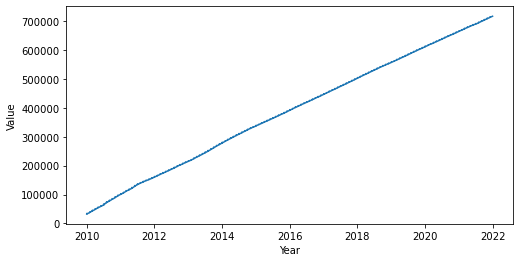

In [3]:
plt.figure(figsize=(8,4))
plt.plot(block_height["Timestamp"], block_height["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

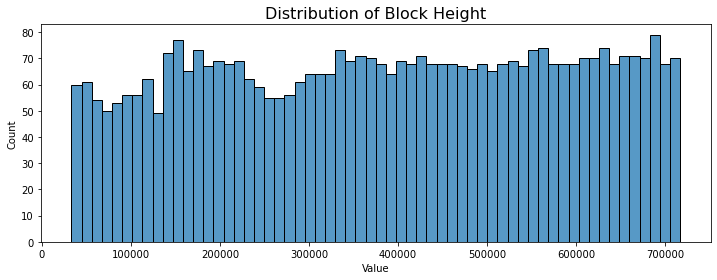

In [4]:
plt.figure(figsize=(12,4))
sns.histplot(block_height["Value"], kde = False, bins = 60)
plt.title('Distribution of Block Height', fontsize=16)
plt.show()

In [6]:
block_height_market = block_height
################ RIMUOVO DATE INIZIO 2010
block_height_market = block_height_market[~(block_height_market['Timestamp'] < '2010-06-06')]

#%matplotlib notebook

#MARKET PRICE
market_price = pd.read_csv("data/market-price.csv")

market_price['Timestamp'] = market_price['Timestamp'].str.split(' ').str[0]
market_price["Timestamp"] = pd.to_datetime(market_price["Timestamp"])
market_price = market_price.rename(columns={'market-price': 'Price'})

market_price = market_price[~(market_price['Timestamp'] < '2009-01-01')]
market_price = market_price[~(market_price['Timestamp'] > '2021-12-31')]

In [20]:
#bh_market = block_height.set_index(['Timestamp']).reindex(market_price.set_index(['Timestamp']).index)
##bh_market.index.year.value_counts() # a causa dei bisestili certi anni ci sono 122 e altri 121 dati, non penso sia un problema
#bh = bh_market.dropna()
#bhm = pd.concat([market_price.set_index(['Timestamp']), bh], axis=1).dropna()
#bhm = bhm.loc[bhm.index> "2010-12-31",:] # tolgo gli zeri
##bhm['diff'] = np.log(bhm['Value'])-np.log(bhm['Price'])

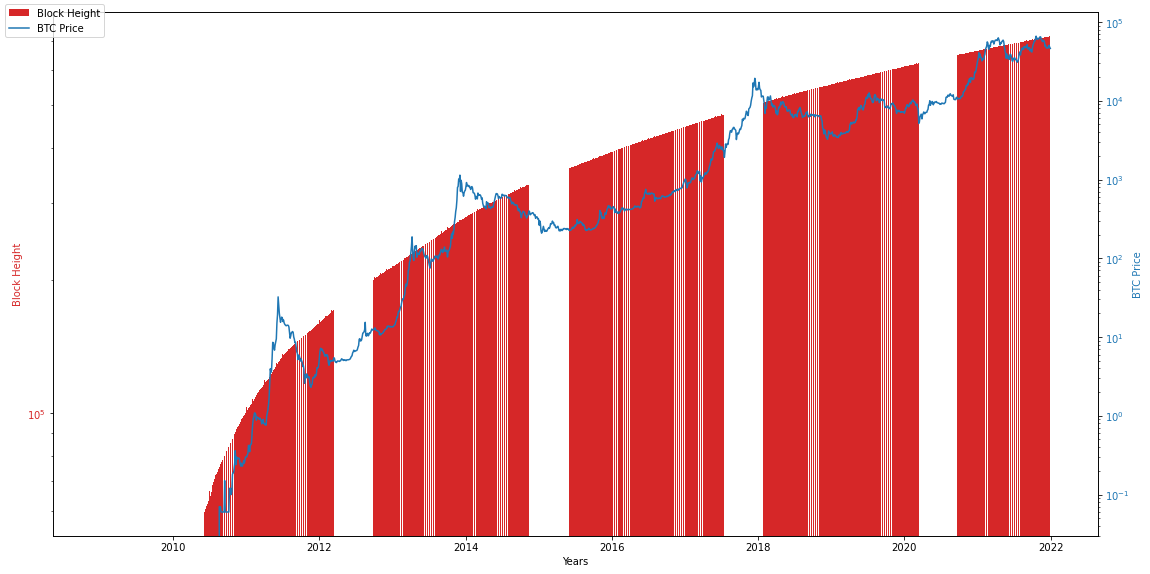

In [44]:
################ RIMUOVO DATE 2009 E 2022

fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('Years')
ax1.set_ylabel('Block Height', color=color)
ax1.bar(block_height_market["Timestamp"], block_height_market["Value"], color=color, label='Block Height')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('BTC Price', color=color)  # we already handled the x-label with ax1
ax2.plot(market_price["Timestamp"], market_price["Price"], color=color, label='BTC Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.legend(loc="upper left")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Shorter time series
Same as market price

In [3]:
blockh = block_height.loc[(block_height["Timestamp"].dt.year > 2016) & (block_height["Timestamp"].dt.year < 2022),:]
blockn = block_height.loc[(block_height["Timestamp"].dt.year > 2016) & (block_height["Timestamp"].dt.year < 2021),:]
blocknh = block_height.loc[(block_height["Timestamp"].dt.year > 2012) & (block_height["Timestamp"].dt.year < 2021),:]
blockf = block_height.loc[(block_height["Timestamp"].dt.year > 2012) & (block_height["Timestamp"].dt.year < 2022),:]

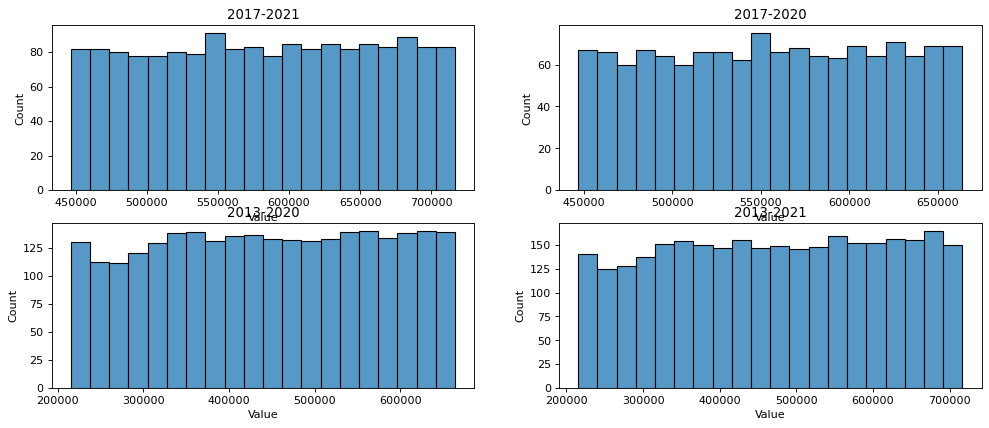

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15,6), dpi= 80)
sns.histplot(blockh["Value"], ax=axes[0,0],bins = 20)
sns.histplot(blockn["Value"], ax=axes[0,1],bins = 20)
sns.histplot(blocknh["Value"], ax=axes[1,0],bins = 20)
sns.histplot(blockf["Value"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

#### Checking monthly seasonality using multiple lines
Price follows a certain repetitive pattern every year? 

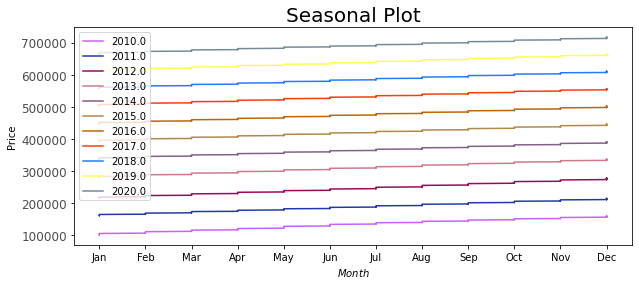

In [11]:
# Prepare data
#block_height['year'] = [d.year for d in block_height["Timestamp"]]
block_height['month'] = [d.strftime('%b') for d in block_height["Timestamp"]]
years = block_height['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(matplotlib.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(10,4))
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', "Value", data=block_height.loc[block_height.year==y, :], color=mycolors[i], label=y)

# Decoration
plt.gca().set(ylabel= "Price", xlabel = '$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot", fontsize=20)
plt.legend(years, loc='upper left')
plt.show()

#### Checking trend using boxplot
Price follows a yearly trend or monthly seasonality? 

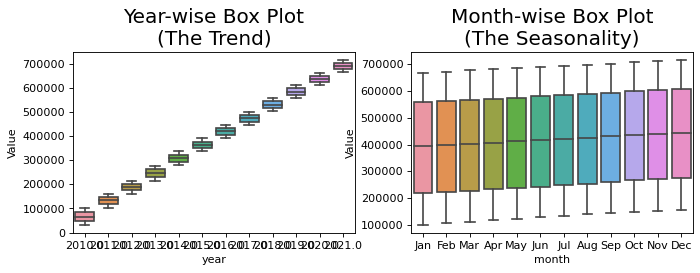

In [13]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(10,3), dpi= 80)
sns.boxplot(x='year', y="Value", data=block_height, ax=axes[0])
sns.boxplot(x='month', y="Value", data=block_height.loc[~block_height.year.isin([2010, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Text(0.5, 0.98, 'BLOCK HEIGHT / 2013-2021 ')

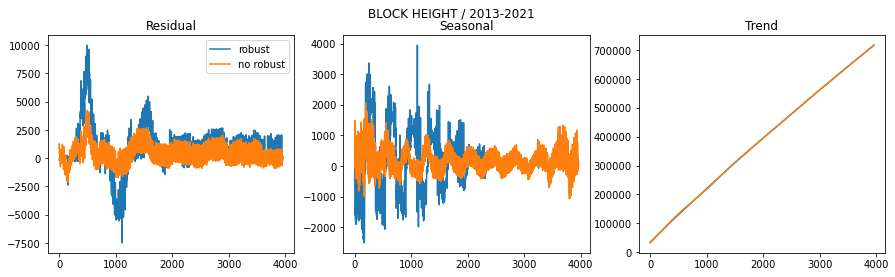

In [14]:
res1 = STL(block_height["Value"], period=365, robust=True).fit()
res2 = STL(block_height["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,4))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')

fig.suptitle('BLOCK HEIGHT / 2013-2021 ')

Text(0.5, 0.98, 'BLOCK HEIGHT / 2017-2021 ')

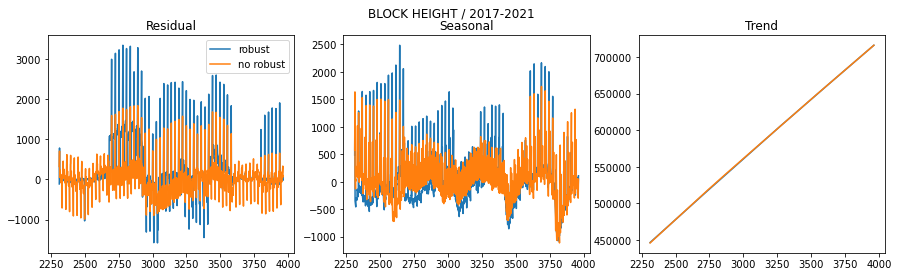

In [15]:
res3 = STL(blockh["Value"], period=365, robust=True).fit()
res4 = STL(blockh["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,4))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')

fig.suptitle('BLOCK HEIGHT / 2017-2021 ')

#### Trend interpolation
We now try to interploate the trend with an exponential function.

In [20]:
# y = a*exp(bx) --> log(y) = log(a)+bx
idx = np.isfinite(np.arange(len(blockh))) & np.isfinite(np.log(res3.trend))
coefs = np.polyfit(np.arange(len(blockh))[idx]+1, np.log(res3.trend)[idx],1)
coefs
# y = exp(coefs[1])*exp(coefs[0]*x)

array([2.84341740e-04, 1.30318146e+01])

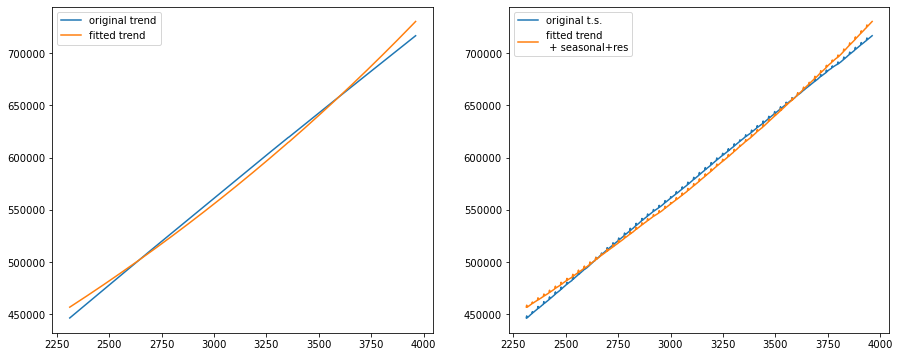

In [22]:
fitted = pd.Series(np.exp(coefs[1])*np.exp(coefs[0]*(np.arange(len(blockh))+1)), index = blockh.index)

fitted_season = fitted+res3.seasonal # fitted trend + seasonal decomposed series (orange) non so se ha senso calcolarlo
fitted_compl = fitted_season+res3.resid # fitted trend + seasonal decomposed series + residual decomposed series (green)

fig, axs = plt.subplots(ncols=2, figsize=(15,6))
axs[0].plot(res3.trend, label="original trend")
axs[0].plot(fitted, label="fitted trend")
axs[0].legend()
axs[1].plot(blockh["Value"], label='original t.s.')
#axs[1].plot(fitted_season, label='fitted trend\n + seasonal')
axs[1].plot(fitted_compl, label='fitted trend\n + seasonal+res')
axs[1].legend()

# TRAIN/VAL/TEST SPLIT

In [4]:
series = block_height['Value']

# Create train data set
train_split_date = '2018-12-31'
train_split_index = np.where(block_height.Timestamp == train_split_date)[0][0]
x_train = block_height.loc[block_height['Timestamp'] <= train_split_date]['Value']

# Create test data set
test_split_date = '2020-06-29'
test_split_index = np.where(block_height.Timestamp == test_split_date)[0][0]
x_test = block_height.loc[block_height['Timestamp'] >= test_split_date]['Value']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = block_height.loc[(block_height['Timestamp'] < test_split_date) & 
                           (block_height['Timestamp'] > train_split_date)]['Value']

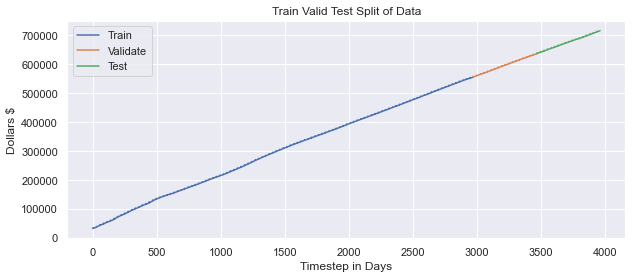

In [5]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 4]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()

In [9]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.


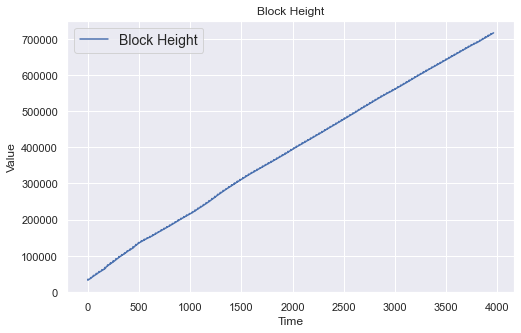

In [6]:
# Plot chart with all details untouched
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """[Plot the series data over a time range]
    Args:
        time (data range): [The entire time span of the data in range format]
        series ([integers]): [Series value corresponding to its point on the time axis]
        format (str, optional): [Graph type]. Defaults to "-".
        start (int, optional): [Time to start time series data]. Defaults to 0.
        end ([type], optional): [Where to stop time data]. Defaults to None.
        label ([str], optional): [Label name of series]. Defaults to None.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(label)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
plot_series(time=block_height.index,series=block_height['Value'], label = 'Block Height')


In [7]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'Block Height Forecast vs Actual')

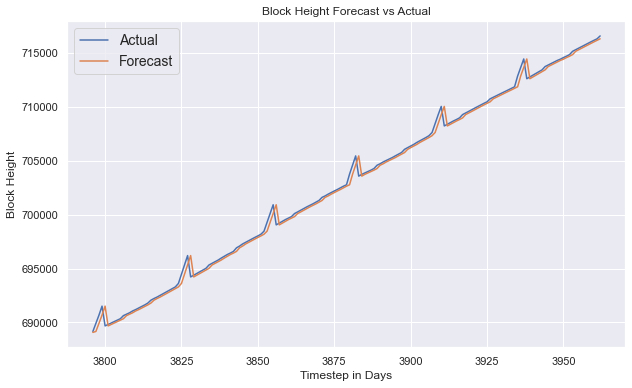

In [35]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('Block Height')
plt.xlabel('Timestep in Days')
plt.title('Block Height Forecast vs Actual')

## Calculate Error in Naive Model

In [10]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = mean_absolute_error(x_test, naive_forecast)
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores

{'naive': 288.7424547283702}

ADESSO VADO A CREARE 2 MODELLI: 20 DAY E 5 DAY MOVING AVERAGE. MOTIVO SARA' ANCHE SPIEGATO NELLE CELLE SEGUENTI, TUTTAVIA FACCIO UNA PRECISAZIONE
- IL MODELLO 5MA SERVE A MODELLARE I 5 GIORNI DELLA SETTIMANA, IN QUANTO LA BORSA E' APERTA DA LUNEDI' A VENERDI', MENTRE GLI ALTRI GIORNI CHIUDE. 
- IL MODELLO 20MA E' COME IL PRECEDENTE, PERO' MENSILE, QUINDI MODELLA I 20 GIORNI IN CUI LA BORSA E' APERTA IN UN MESE.

TUTTO QUESTO NON VALE PER BITCOIN E CRYPTO, IN QUANTO E' SEMPRE POSSIBILE TRADARLI, OGNI ISTANTE.
IN OGNI CASO CI STA FARE QUESTA ANALISI, IN QUANTO MAGARI LA BORSA POTREBBE INFLUENZARE ANCHE LE CRYPTO

# Monthly Moving Average Model (20 Day MA)

Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.

Text(0.5, 1.0, 'SMA20 vs Actual')

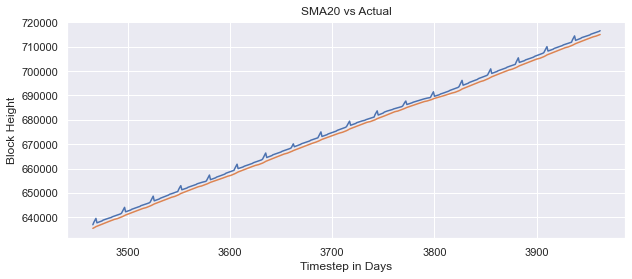

In [12]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = block_height['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index:]
                                         
plt.figure(figsize=(10, 4))
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, moving_avg_forecast)
plt.ylabel('Block Height')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')

In [13]:
ma_20 = mean_absolute_error(x_test, moving_avg_forecast)

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 288.7424547283702, 'SMA 20': 1523.8221327967783}

# Weekly Moving Average (5 day MA)

I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

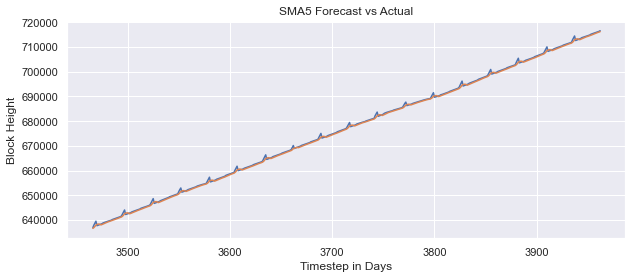

In [14]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = block_height['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index: ]
                                         
plt.figure(figsize=(10, 4))
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, moving_avg_forecast)
plt.ylabel('Block Height')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [15]:
# Calculate MAE
ma_5 = mean_absolute_error(x_test, moving_avg_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 288.7424547283702,
 'SMA 20': 1523.8221327967783,
 'SMA 5': 418.7424547283716}

# ARIMA

Step 1: Is the data stationary?
Use Augmented Dickey Fuller test to determine if the data is stationary

- Failure to reject the null hypothesis means the data is not stationary

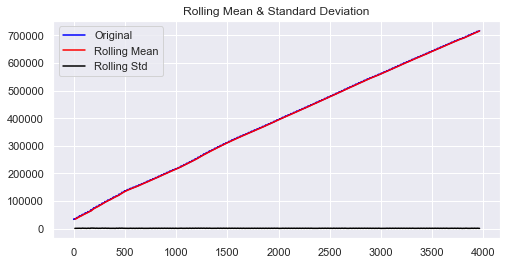

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.257996e+00
p-value                        4.291715e-08
#Lags Used                     1.700000e+01
Number of Observations Used    3.942000e+03
Critical Value (1%)           -3.432010e+00
Critical Value (5%)           -2.862273e+00
Critical Value (10%)          -2.567160e+00
dtype: float64


In [16]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(8, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(series)


The p-value is obtained is lower than significance level of 0.05 and the ADF statistic is lower than any of the critical values.

However, seeing the graph, the series is clearly not stationary.

# Step 2 Differencing

We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.


In [17]:
# Get the difference of each Adj Close point
bh_diff_1 = series.diff()
primo = series[0]

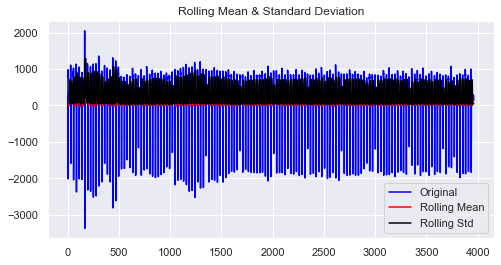

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -22.898999
p-value                           0.000000
#Lags Used                       15.000000
Number of Observations Used    3943.000000
Critical Value (1%)              -3.432010
Critical Value (5%)              -2.862273
Critical Value (10%)             -2.567160
dtype: float64


In [18]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(bh_diff_1.dropna())

# Step 3: Autocorrelation and Partial autocorrelation
Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

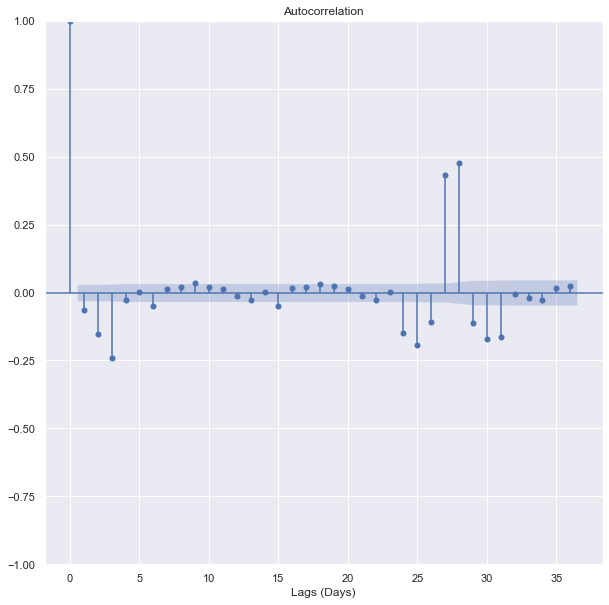

In [65]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(bh_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

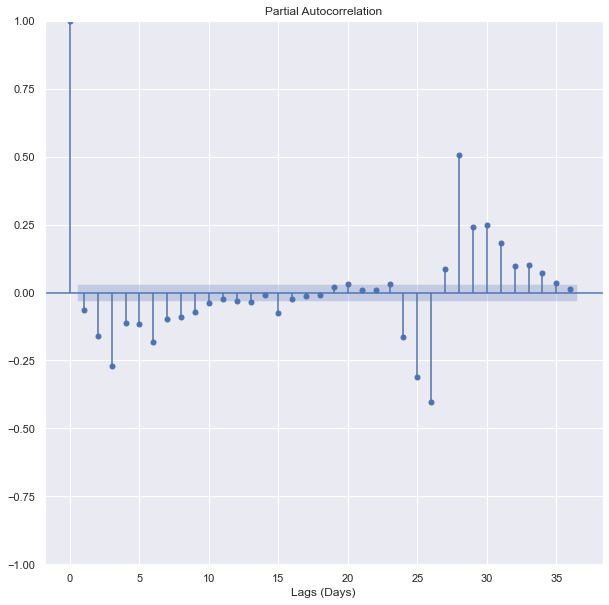

In [66]:
plot_pacf(bh_diff_1, method='ywm')
plt.xlabel('Lags (Days)')
plt.show()

- Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, we will use the 1st lag as a moving average point.

- For the PACF plot, at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.

- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term.

SINCE THE DIFF SERIES IS THE ONLY STATIONARY ONE WE USE IT TO BUILD AND TRAIN THE MODELS. WE WILL RECONSTRUCT THE ORIGINAL SERIES REVERSEING THE DIFFERENCIATION.

We now split the diff series in train, test and validation

In [19]:
# Create train data set

x_train_diff = bh_diff_1.loc[block_height['Timestamp'] <= train_split_date]

# Create test data set
x_test_diff = bh_diff_1.loc[block_height['Timestamp'] >= test_split_date]

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid_diff = bh_diff_1.loc[(block_height['Timestamp'] < test_split_date) & 
                           (block_height['Timestamp'] > train_split_date)]

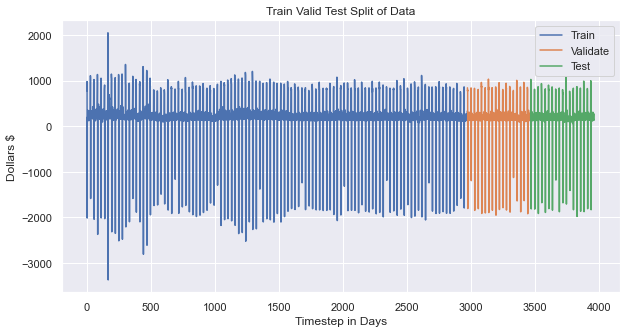

In [77]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 5]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train_diff, label = 'Train')
plt.plot(x_valid_diff, label = 'Validate')
plt.plot(x_test_diff, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()

### Testing different arima models

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=inf, Time=0.98 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=47239.339, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=46582.046, Time=0.12 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=inf, Time=0.59 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=46580.265, Time=0.05 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=46582.052, Time=0.12 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=46553.178, Time=0.56 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=46524.815, Time=0.94 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=46583.352, Time=0.23 sec
 ARIMA(1,2,0)(2,0,2)[7]             : AIC=46503.899, Time=0.90 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=46491.981, Time=1.53 sec
 ARIMA(1,2,0)(0,0,2)[7]             : AIC=46583.652, Time=0.27 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=47201.795, Time=0.76 sec
 ARIMA(2,2,0)(1,0,2)[7]             : AIC=46407.110, T

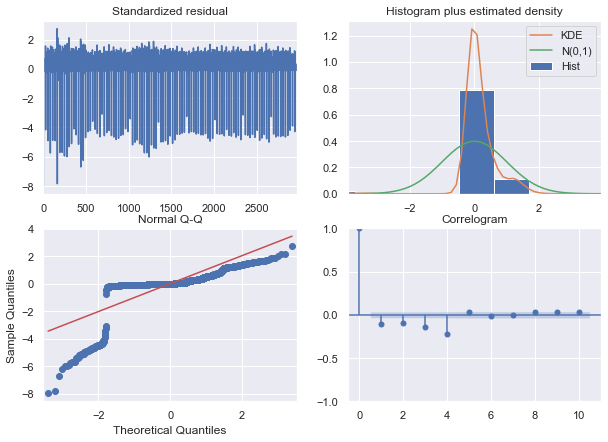

In [20]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(x_train, exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = seasonal_flag, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

    
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'

input_seasonality = 7

# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
actuals = x_test.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train_diff, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train)


Abbiamo trovato che il miglior modello è ARIMA(3,2,0)(0,0,1)[7]. Quindi ancora devo studiare la seasonality per capire se trovo qualche valore migliore, e in caso aggiungere sotto.

In [21]:
import statsmodels.api as sm

# fit model
block_arima = sm.tsa.arima.ARIMA(x_train_diff.dropna(), order=(3, 2,0), seasonal_order=(0,0,1,7))
block_arima_fit = block_arima.fit()
print(block_arima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Value   No. Observations:                 2969
Model:             ARIMA(3, 2, 0)x(0, 0, [1], 7)   Log Likelihood              -23818.961
Date:                           Fri, 04 Nov 2022   AIC                          47647.922
Time:                                   09:21:51   BIC                          47677.898
Sample:                                        0   HQIC                         47658.711
                                          - 2969                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0843      0.009   -120.787      0.000      -1.102      -1.067
ar.L2         -0.7842      0.017    -47.342

C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


NormaltestResult(statistic=1548.722897469711, pvalue=0.0)
This distribution is not a normal distribution


C:\Users\paletto\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


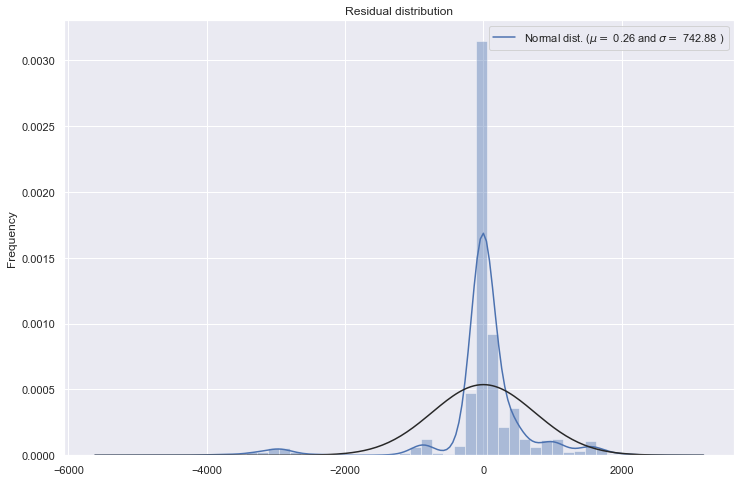

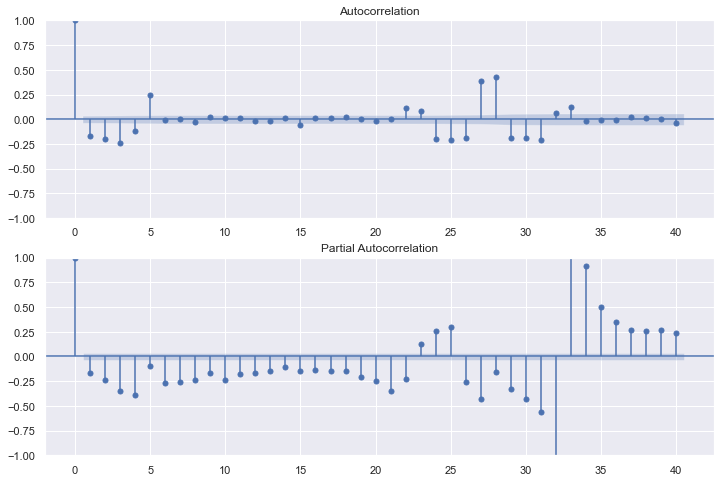

In [83]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = block_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

# Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (0,1,3)(0,0,2,7) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

Ci mette parecchio a calcolare questa cella giù. Se si vuole risparmiare tempo allora bisogna abbassare il numero di data points da predire

### modello 1: Predizione fake: predico ma appendo alla history il valore del test set

In [22]:
# Create list of x train valuess
history = [x for x in x_valid_diff]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test_diff)

# loop through every data point
for time_point in list(x_test_diff.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,2,0), seasonal_order=(0,0,2,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test_diff[time_point]
    history.append(true_test_value)
        
MAE_error = mean_absolute_error(x_test_diff, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

#%store model_predictions

Testing Mean Squared Error is 317.455575850708


In [ ]:
# %store model_predictions
#%store -r model_predictions
# Check to see if it reloaded
#model_predictions[:5]

In [23]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test_diff, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

{'naive': 288.7424547283702,
 'SMA 20': 1523.8221327967783,
 'SMA 5': 418.7424547283716,
 'ARIMA': 317.455575850708}

- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

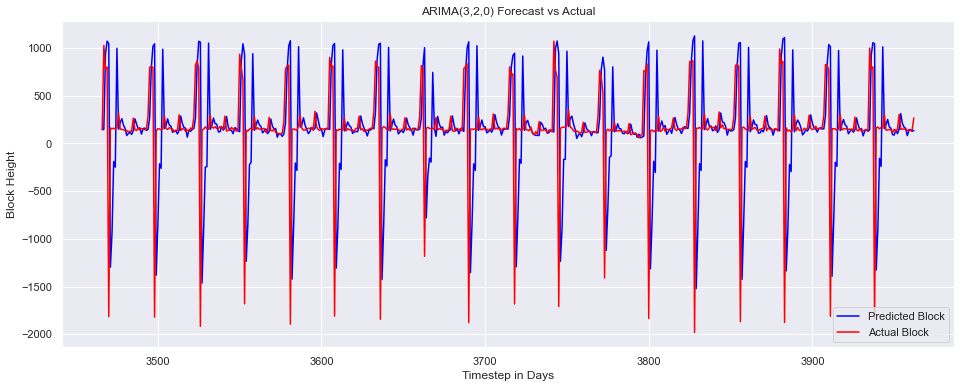

In [99]:
# Plot our predictions against the actual values for a visual comparison.
plt.figure(figsize=(16,6))
plt.plot(x_test_diff.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Block')
plt.plot(x_test_diff.index[-N_test_observations:], x_test_diff[-N_test_observations:], color='red', label='Actual Block')
plt.ylabel('Block Height')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(3,2,0) Forecast vs Actual')
plt.legend()
plt.show()

In [100]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test_diff

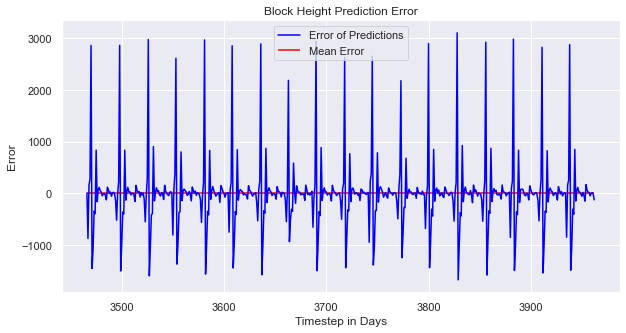

<Figure size 720x432 with 0 Axes>

In [101]:
plt.plot(x_test_diff.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test_diff.index.min(),xmax=x_test_diff.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Block Height Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [24]:
#mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 288.7424547283702,
 'SMA 20': 1523.8221327967783,
 'SMA 5': 418.7424547283716,
 'ARIMA': 317.455575850708}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

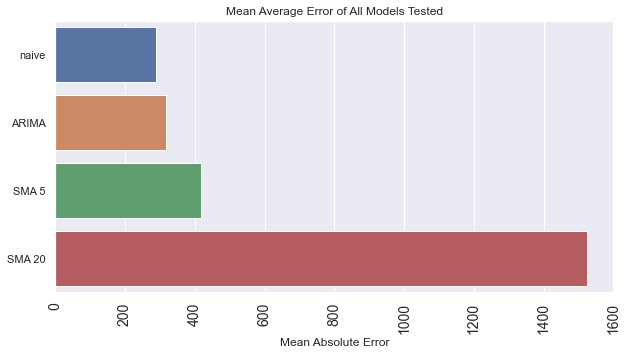

In [104]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

### modello 2: predizioni ricorsive: predico e appendo a history il valore predetto

Non lo usiamo più

In [ ]:
# Create list of x train valuess
history = [x for x in x_valid]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#in questo modo prendo oggi, prevedo domani, appendo la previsione al trainset, retraino, predico ancora. 
#Questo è recursive learning, o autoregressive learning
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,2,0), seasonal_order=(0,0,2,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Fees')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Fees')
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.show()

### modello 3: uso il modello trainato senza riaggiornarlo

In [25]:
history = [x for x in x_valid_diff]
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test_diff)

model = sm.tsa.arima.ARIMA(history, order=(3,2,0), seasonal_order=(0,0,1,7))
model_fit = model.fit()

output = model_fit.forecast(N_test_observations)
for el in output:
    model_predictions.append(el)
    history.append(el)

MAE_error = mean_absolute_error(x_test_diff, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

Testing Mean Squared Error is 271.30754117987044


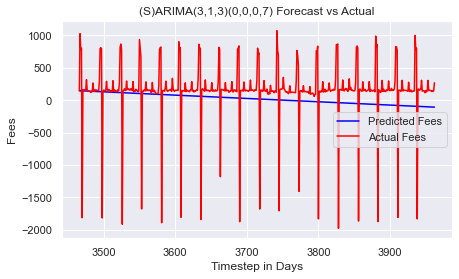

In [26]:
plt.figure(figsize=(7,4))
plt.plot(x_test_diff.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Fees')
plt.plot(x_test_diff.index[-N_test_observations:], x_test_diff[-N_test_observations:], color='red', label='Actual Fees')
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.show()

In [27]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test_diff, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA 2'] = arima_mae
model_mae_scores

{'naive': 288.7424547283702,
 'SMA 20': 1523.8221327967783,
 'SMA 5': 418.7424547283716,
 'ARIMA': 317.455575850708,
 'ARIMA 2': 271.30754117987044}

# LSTM

- LSTM stands for Long Short Term Memory
The LSTM cell contains an RNN cell inside (dense layer with a tanh activation function), but it has other attributes that allow it to remember patterns over a longer period of time. The LSTM contains a short-term state vector that is used from one time step to the next identical to the RNN cell.

Where LSTM cells differ is their Long-Term State vector. This long term state vector undergoes a multipicative and additive operation at each time step.The long term state vector starts off with a "forget gate" which is simply a sigmoid activation on top of a dense layer which produces an output from 0 - 1. This means if the forget gate ourputs a value of 1 then the long term state vector remains unchanged. On the opposite end, if the output valuse of the dense layer is 0 the long term state vector is nullified. This helps adjust quickly to highly volatile environments. If we are in a steady uptrend and then we suddenly have a big drop in the market, the long term state vector will be erased so the model can readjust quickly.

The next gate is the input gate. The input gate is much like the forget gate, except it decides if the short term state vector gets added to the long term vector or is erased.

The last gate called the "output gate" decides what the next hidden state should be. It is important to know that this hidden state output is the prediction for the next time step. Here, the previous hidden state (previous cell output) amd current input are jammed together through sigmoid function. Then we take our newly modified long term state vector which has already passed through the forget and input gates, and apply a tanh function to it. Finally, multiple both the tanh output (long term state vector output) and the sigmoid function output (previous hidden state and new input at this time step) to what information the hidden state needs to carry to the next time step.

</br> To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.

In [28]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 5]

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [29]:
# Reshape values
x_train_values = x_train_diff.dropna().values.reshape(-1, 1)
x_valid_values = x_valid_diff.values.reshape(-1, 1)
x_test_values = x_test_diff.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [30]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

### Find the learning rate

In [31]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

C:\Users\paletto\Anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/100
148/148 [==============================] - 3s 7ms/step - loss: 0.1884 - mae: 0.6044 - lr: 1.0000e-05
Epoch 2/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0630 - mae: 0.3325 - lr: 1.1220e-05
Epoch 3/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0055 - mae: 0.0579 - lr: 1.2589e-05
Epoch 4/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0044 - mae: 0.0368 - lr: 1.4125e-05
Epoch 5/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0044 - mae: 0.0368 - lr: 1.5849e-05
Epoch 6/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0044 - mae: 0.0368 - lr: 1.7783e-05
Epoch 7/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0044 - mae: 0.0368 - lr: 1.9953e-05
Epoch 8/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0044 - mae: 0.0368 - lr: 2.2387e-05
Epoch 9/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0044 - mae: 0.0368 

148/148 [==============================] - 1s 5ms/step - loss: 0.0038 - mae: 0.0344 - lr: 0.0398
Epoch 74/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0038 - mae: 0.0345 - lr: 0.0447
Epoch 75/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0038 - mae: 0.0347 - lr: 0.0501
Epoch 76/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0038 - mae: 0.0350 - lr: 0.0562
Epoch 77/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0039 - mae: 0.0355 - lr: 0.0631
Epoch 78/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0039 - mae: 0.0360 - lr: 0.0708
Epoch 79/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0039 - mae: 0.0366 - lr: 0.0794
Epoch 80/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0039 - mae: 0.0374 - lr: 0.0891
Epoch 81/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0039 - mae: 0.0384 - lr: 0.1000
Epoch 82/100
148/148 [=

(1e-05, 0.1, 0.0, 0.03)

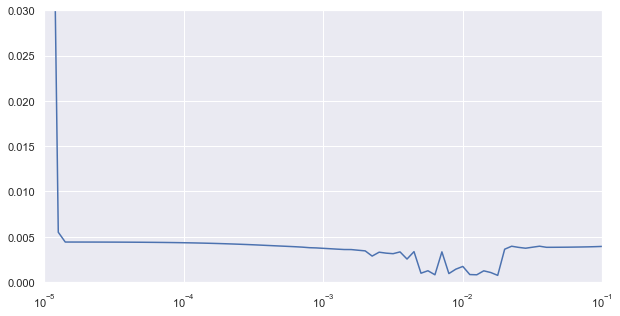

In [32]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 0.03])

In [33]:
#This is the best learning rate
history.history["loss"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 4e-6

0.000736190180759877

In [36]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=7e-4)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

C:\Users\paletto\Anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/500
    147/Unknown - 2s 5ms/step - loss: 0.0094 - mae: 0.0592

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 6s 31ms/step - loss: 0.0094 - mae: 0.0592 - val_loss: 0.0034 - val_mae: 0.0323
Epoch 2/500
144/148 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0426

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0046 - mae: 0.0424 - val_loss: 0.0033 - val_mae: 0.0325
Epoch 3/500
148/148 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0407

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 30ms/step - loss: 0.0044 - mae: 0.0407 - val_loss: 0.0033 - val_mae: 0.0326
Epoch 4/500
141/148 [===========================>..] - ETA: 0s - loss: 0.0044 - mae: 0.0401

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 27ms/step - loss: 0.0043 - mae: 0.0398 - val_loss: 0.0033 - val_mae: 0.0327
Epoch 5/500
143/148 [===========================>..] - ETA: 0s - loss: 0.0043 - mae: 0.0394

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0042 - mae: 0.0392 - val_loss: 0.0033 - val_mae: 0.0327
Epoch 6/500
139/148 [===========================>..] - ETA: 0s - loss: 0.0043 - mae: 0.0393

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 30ms/step - loss: 0.0042 - mae: 0.0390 - val_loss: 0.0033 - val_mae: 0.0326
Epoch 7/500
142/148 [===========================>..] - ETA: 0s - loss: 0.0042 - mae: 0.0392

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 28ms/step - loss: 0.0041 - mae: 0.0390 - val_loss: 0.0032 - val_mae: 0.0326
Epoch 8/500
143/148 [===========================>..] - ETA: 0s - loss: 0.0041 - mae: 0.0396

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0041 - mae: 0.0396 - val_loss: 0.0032 - val_mae: 0.0335
Epoch 9/500
148/148 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0404

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0040 - mae: 0.0404 - val_loss: 0.0032 - val_mae: 0.0352
Epoch 10/500
139/148 [===========================>..] - ETA: 0s - loss: 0.0041 - mae: 0.0417

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 30ms/step - loss: 0.0040 - mae: 0.0413 - val_loss: 0.0032 - val_mae: 0.0381
Epoch 11/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0039 - mae: 0.0422 - val_loss: 0.0032 - val_mae: 0.0414
Epoch 12/500
148/148 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0428

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0039 - mae: 0.0428 - val_loss: 0.0031 - val_mae: 0.0418
Epoch 13/500
143/148 [===========================>..] - ETA: 0s - loss: 0.0038 - mae: 0.0431

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0038 - mae: 0.0432 - val_loss: 0.0030 - val_mae: 0.0407
Epoch 14/500
141/148 [===========================>..] - ETA: 0s - loss: 0.0038 - mae: 0.0434

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 30ms/step - loss: 0.0037 - mae: 0.0434 - val_loss: 0.0030 - val_mae: 0.0401
Epoch 15/500
142/148 [===========================>..] - ETA: 0s - loss: 0.0037 - mae: 0.0436

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0037 - mae: 0.0435 - val_loss: 0.0030 - val_mae: 0.0395
Epoch 16/500
146/148 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0441

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 30ms/step - loss: 0.0037 - mae: 0.0439 - val_loss: 0.0029 - val_mae: 0.0385
Epoch 17/500
148/148 [==============================] - ETA: 0s - loss: 0.0036 - mae: 0.0438

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0036 - mae: 0.0438 - val_loss: 0.0029 - val_mae: 0.0389
Epoch 18/500
145/148 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0439

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 27ms/step - loss: 0.0036 - mae: 0.0438 - val_loss: 0.0029 - val_mae: 0.0395
Epoch 19/500
140/148 [===========================>..] - ETA: 0s - loss: 0.0035 - mae: 0.0440

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0035 - mae: 0.0440 - val_loss: 0.0028 - val_mae: 0.0401
Epoch 20/500
138/148 [==========================>...] - ETA: 0s - loss: 0.0035 - mae: 0.0449

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 28ms/step - loss: 0.0034 - mae: 0.0448 - val_loss: 0.0027 - val_mae: 0.0410
Epoch 21/500
139/148 [===========================>..] - ETA: 0s - loss: 0.0034 - mae: 0.0457

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 28ms/step - loss: 0.0033 - mae: 0.0453 - val_loss: 0.0025 - val_mae: 0.0405
Epoch 22/500
141/148 [===========================>..] - ETA: 0s - loss: 0.0032 - mae: 0.0439

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 28ms/step - loss: 0.0031 - mae: 0.0435 - val_loss: 0.0023 - val_mae: 0.0415
Epoch 23/500
148/148 [==============================] - 1s 5ms/step - loss: 0.0030 - mae: 0.0435 - val_loss: 0.0024 - val_mae: 0.0430
Epoch 24/500
141/148 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0417

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 28ms/step - loss: 0.0025 - mae: 0.0413 - val_loss: 0.0021 - val_mae: 0.0429
Epoch 25/500
141/148 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0401

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 28ms/step - loss: 0.0022 - mae: 0.0398 - val_loss: 0.0017 - val_mae: 0.0355
Epoch 26/500
147/148 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0363

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0018 - mae: 0.0362 - val_loss: 0.0011 - val_mae: 0.0298
Epoch 27/500
140/148 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0355

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 28ms/step - loss: 0.0016 - mae: 0.0350 - val_loss: 0.0011 - val_mae: 0.0291
Epoch 28/500
146/148 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0331

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 28ms/step - loss: 0.0015 - mae: 0.0329 - val_loss: 0.0011 - val_mae: 0.0283
Epoch 29/500
145/148 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0334

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0014 - mae: 0.0332 - val_loss: 0.0011 - val_mae: 0.0278
Epoch 30/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0014 - mae: 0.0326 - val_loss: 0.0012 - val_mae: 0.0308
Epoch 31/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0014 - mae: 0.0322 - val_loss: 0.0011 - val_mae: 0.0291
Epoch 32/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0014 - mae: 0.0320 - val_loss: 0.0011 - val_mae: 0.0279
Epoch 33/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0014 - mae: 0.0324 - val_loss: 0.0011 - val_mae: 0.0267
Epoch 34/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0015 - mae: 0.0333 - val_loss: 0.0018 - val_mae: 0.0453
Epoch 35/500
140/148 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0295

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0012 - mae: 0.0294 - val_loss: 9.6868e-04 - val_mae: 0.0257
Epoch 36/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0013 - mae: 0.0298 - val_loss: 0.0011 - val_mae: 0.0289
Epoch 37/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0343 - val_loss: 9.9436e-04 - val_mae: 0.0284
Epoch 38/500
140/148 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0271

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 0.0010 - mae: 0.0269 - val_loss: 9.3351e-04 - val_mae: 0.0271
Epoch 39/500
141/148 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0272

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 28ms/step - loss: 0.0011 - mae: 0.0270 - val_loss: 7.6956e-04 - val_mae: 0.0225
Epoch 40/500
145/148 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0273

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 5s 31ms/step - loss: 0.0010 - mae: 0.0271 - val_loss: 7.4119e-04 - val_mae: 0.0219
Epoch 41/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0010 - mae: 0.0260 - val_loss: 7.5182e-04 - val_mae: 0.0231
Epoch 42/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0011 - mae: 0.0268 - val_loss: 7.5163e-04 - val_mae: 0.0247
Epoch 43/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0013 - mae: 0.0302 - val_loss: 8.5061e-04 - val_mae: 0.0246
Epoch 44/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0011 - mae: 0.0277 - val_loss: 8.7333e-04 - val_mae: 0.0286
Epoch 45/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0011 - mae: 0.0282 - val_loss: 9.1210e-04 - val_mae: 0.0297
Epoch 46/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0011 - mae: 0.0277 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 47/500
142/148 [===========================>

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 30ms/step - loss: 0.0012 - mae: 0.0289 - val_loss: 7.3500e-04 - val_mae: 0.0202
Epoch 48/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0010 - mae: 0.0271 - val_loss: 8.0233e-04 - val_mae: 0.0261
Epoch 49/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0010 - mae: 0.0266 - val_loss: 8.1410e-04 - val_mae: 0.0256
Epoch 50/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0011 - mae: 0.0273 - val_loss: 9.2737e-04 - val_mae: 0.0236
Epoch 51/500
148/148 [==============================] - 1s 5ms/step - loss: 0.0013 - mae: 0.0292 - val_loss: 8.7237e-04 - val_mae: 0.0253
Epoch 52/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0012 - mae: 0.0286 - val_loss: 9.4624e-04 - val_mae: 0.0307
Epoch 53/500
148/148 [==============================] - 1s 6ms/step - loss: 0.0011 - mae: 0.0278 - val_loss: 8.9255e-04 - val_mae: 0.0274
Epoch 54/500
148/148 [========================

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 30ms/step - loss: 0.0010 - mae: 0.0268 - val_loss: 7.0677e-04 - val_mae: 0.0217
Epoch 62/500
140/148 [===========================>..] - ETA: 0s - loss: 9.8612e-04 - mae: 0.0260

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 9.5758e-04 - mae: 0.0256 - val_loss: 6.4441e-04 - val_mae: 0.0212
Epoch 63/500
148/148 [==============================] - 1s 5ms/step - loss: 8.9684e-04 - mae: 0.0249 - val_loss: 7.5243e-04 - val_mae: 0.0266
Epoch 64/500
148/148 [==============================] - 1s 6ms/step - loss: 8.7607e-04 - mae: 0.0245 - val_loss: 7.7821e-04 - val_mae: 0.0293
Epoch 65/500
148/148 [==============================] - 1s 5ms/step - loss: 0.0013 - mae: 0.0302 - val_loss: 7.4895e-04 - val_mae: 0.0214
Epoch 66/500
138/148 [==========================>...] - ETA: 0s - loss: 8.4753e-04 - mae: 0.0218

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 8.1459e-04 - mae: 0.0215 - val_loss: 6.1030e-04 - val_mae: 0.0203
Epoch 67/500
148/148 [==============================] - 1s 6ms/step - loss: 7.9441e-04 - mae: 0.0223 - val_loss: 8.2423e-04 - val_mae: 0.0283
Epoch 68/500
148/148 [==============================] - 1s 6ms/step - loss: 8.9000e-04 - mae: 0.0250 - val_loss: 8.2372e-04 - val_mae: 0.0314
Epoch 69/500
148/148 [==============================] - 1s 6ms/step - loss: 8.6011e-04 - mae: 0.0240 - val_loss: 8.1122e-04 - val_mae: 0.0269
Epoch 70/500
148/148 [==============================] - 1s 5ms/step - loss: 8.9896e-04 - mae: 0.0250 - val_loss: 6.9362e-04 - val_mae: 0.0223
Epoch 71/500
148/148 [==============================] - 1s 6ms/step - loss: 8.3199e-04 - mae: 0.0234 - val_loss: 0.0011 - val_mae: 0.0306
Epoch 72/500
148/148 [==============================] - 1s 5ms/step - loss: 9.1089e-04 - mae: 0.0252 - val_loss: 9.8796e-04 - val_mae: 0.0314
Epoch 73/500
148/148 [

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 7.9610e-04 - mae: 0.0230 - val_loss: 5.7812e-04 - val_mae: 0.0195
Epoch 82/500
141/148 [===========================>..] - ETA: 0s - loss: 9.5009e-04 - mae: 0.0259

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 28ms/step - loss: 9.2404e-04 - mae: 0.0255 - val_loss: 5.4365e-04 - val_mae: 0.0193
Epoch 83/500
148/148 [==============================] - 1s 6ms/step - loss: 7.0547e-04 - mae: 0.0208 - val_loss: 5.8490e-04 - val_mae: 0.0186
Epoch 84/500
146/148 [============================>.] - ETA: 0s - loss: 7.4649e-04 - mae: 0.0213

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 30ms/step - loss: 7.4097e-04 - mae: 0.0212 - val_loss: 5.1432e-04 - val_mae: 0.0176
Epoch 85/500
148/148 [==============================] - 1s 6ms/step - loss: 6.7208e-04 - mae: 0.0204 - val_loss: 5.6574e-04 - val_mae: 0.0186
Epoch 86/500
148/148 [==============================] - 1s 6ms/step - loss: 7.2071e-04 - mae: 0.0217 - val_loss: 5.9258e-04 - val_mae: 0.0185
Epoch 87/500
145/148 [============================>.] - ETA: 0s - loss: 8.9482e-04 - mae: 0.0241

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 8.8315e-04 - mae: 0.0239 - val_loss: 5.0670e-04 - val_mae: 0.0181
Epoch 88/500
148/148 [==============================] - 1s 6ms/step - loss: 6.6527e-04 - mae: 0.0200 - val_loss: 5.3220e-04 - val_mae: 0.0177
Epoch 89/500
148/148 [==============================] - 1s 6ms/step - loss: 6.7353e-04 - mae: 0.0204 - val_loss: 5.2149e-04 - val_mae: 0.0168
Epoch 90/500
148/148 [==============================] - 1s 6ms/step - loss: 8.1391e-04 - mae: 0.0230 - val_loss: 5.7906e-04 - val_mae: 0.0183
Epoch 91/500
148/148 [==============================] - 1s 6ms/step - loss: 7.1137e-04 - mae: 0.0213 - val_loss: 5.1474e-04 - val_mae: 0.0170
Epoch 92/500
146/148 [============================>.] - ETA: 0s - loss: 6.7544e-04 - mae: 0.0203

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 6.7008e-04 - mae: 0.0202 - val_loss: 5.0061e-04 - val_mae: 0.0166
Epoch 93/500
148/148 [==============================] - 1s 6ms/step - loss: 6.8174e-04 - mae: 0.0209 - val_loss: 5.6544e-04 - val_mae: 0.0173
Epoch 94/500
148/148 [==============================] - 1s 6ms/step - loss: 7.1048e-04 - mae: 0.0208 - val_loss: 5.3502e-04 - val_mae: 0.0174
Epoch 95/500
148/148 [==============================] - 1s 6ms/step - loss: 6.2013e-04 - mae: 0.0193 - val_loss: 5.2181e-04 - val_mae: 0.0166
Epoch 96/500
148/148 [==============================] - 1s 6ms/step - loss: 6.2662e-04 - mae: 0.0191 - val_loss: 5.8569e-04 - val_mae: 0.0174
Epoch 97/500
148/148 [==============================] - 1s 6ms/step - loss: 6.7580e-04 - mae: 0.0207 - val_loss: 6.2676e-04 - val_mae: 0.0183
Epoch 98/500
148/148 [==============================] - 1s 6ms/step - loss: 6.2685e-04 - mae: 0.0195 - val_loss: 5.2226e-04 - val_mae: 0.0169
Epoch 99/500
148/1

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 30ms/step - loss: 6.2584e-04 - mae: 0.0193 - val_loss: 4.9851e-04 - val_mae: 0.0165
Epoch 103/500
141/148 [===========================>..] - ETA: 0s - loss: 6.2487e-04 - mae: 0.0190

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 6.0347e-04 - mae: 0.0187 - val_loss: 4.5782e-04 - val_mae: 0.0163
Epoch 104/500
148/148 [==============================] - 1s 6ms/step - loss: 5.9560e-04 - mae: 0.0189 - val_loss: 4.5950e-04 - val_mae: 0.0162
Epoch 105/500
148/148 [==============================] - 1s 6ms/step - loss: 5.9177e-04 - mae: 0.0188 - val_loss: 4.9506e-04 - val_mae: 0.0170
Epoch 106/500
140/148 [===========================>..] - ETA: 0s - loss: 6.0638e-04 - mae: 0.0189

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 28ms/step - loss: 5.8274e-04 - mae: 0.0186 - val_loss: 4.2864e-04 - val_mae: 0.0164
Epoch 107/500
146/148 [============================>.] - ETA: 0s - loss: 6.1139e-04 - mae: 0.0188

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 6.0542e-04 - mae: 0.0187 - val_loss: 4.2360e-04 - val_mae: 0.0155
Epoch 108/500
148/148 [==============================] - 1s 6ms/step - loss: 5.8372e-04 - mae: 0.0187 - val_loss: 4.5135e-04 - val_mae: 0.0168
Epoch 109/500
148/148 [==============================] - 1s 6ms/step - loss: 5.9437e-04 - mae: 0.0186 - val_loss: 4.3690e-04 - val_mae: 0.0162
Epoch 110/500
148/148 [==============================] - 1s 5ms/step - loss: 5.6888e-04 - mae: 0.0181 - val_loss: 4.5524e-04 - val_mae: 0.0164
Epoch 111/500
148/148 [==============================] - 1s 6ms/step - loss: 5.5585e-04 - mae: 0.0180 - val_loss: 4.2721e-04 - val_mae: 0.0159
Epoch 112/500
148/148 [==============================] - 1s 6ms/step - loss: 5.6169e-04 - mae: 0.0182 - val_loss: 4.7337e-04 - val_mae: 0.0165
Epoch 113/500
148/148 [==============================] - 1s 6ms/step - loss: 5.5769e-04 - mae: 0.0181 - val_loss: 5.2755e-04 - val_mae: 0.0169
Epoch 114/50

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 29ms/step - loss: 5.6200e-04 - mae: 0.0183 - val_loss: 4.0226e-04 - val_mae: 0.0157
Epoch 115/500
148/148 [==============================] - 1s 5ms/step - loss: 5.8908e-04 - mae: 0.0185 - val_loss: 6.2322e-04 - val_mae: 0.0178
Epoch 116/500
148/148 [==============================] - 1s 5ms/step - loss: 5.6136e-04 - mae: 0.0179 - val_loss: 4.0257e-04 - val_mae: 0.0148
Epoch 117/500
148/148 [==============================] - 1s 6ms/step - loss: 5.8778e-04 - mae: 0.0187 - val_loss: 5.0374e-04 - val_mae: 0.0162
Epoch 118/500
147/148 [============================>.] - ETA: 0s - loss: 5.4460e-04 - mae: 0.0178

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


148/148 [==============================] - 4s 28ms/step - loss: 5.4256e-04 - mae: 0.0178 - val_loss: 3.9185e-04 - val_mae: 0.0146
Epoch 119/500
148/148 [==============================] - 1s 6ms/step - loss: 5.7794e-04 - mae: 0.0186 - val_loss: 4.2938e-04 - val_mae: 0.0154
Epoch 120/500
148/148 [==============================] - 1s 6ms/step - loss: 5.3589e-04 - mae: 0.0175 - val_loss: 3.9828e-04 - val_mae: 0.0149
Epoch 121/500
148/148 [==============================] - 1s 5ms/step - loss: 5.5442e-04 - mae: 0.0178 - val_loss: 4.4342e-04 - val_mae: 0.0166
Epoch 122/500
148/148 [==============================] - 1s 5ms/step - loss: 5.3628e-04 - mae: 0.0181 - val_loss: 4.0758e-04 - val_mae: 0.0166
Epoch 123/500
148/148 [==============================] - 1s 5ms/step - loss: 5.3460e-04 - mae: 0.0180 - val_loss: 4.4196e-04 - val_mae: 0.0164
Epoch 124/500
148/148 [==============================] - 1s 6ms/step - loss: 6.4414e-04 - mae: 0.0201 - val_loss: 4.4579e-04 - val_mae: 0.0151
Epoch 125/50

### Make predictions: fake

In [37]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()

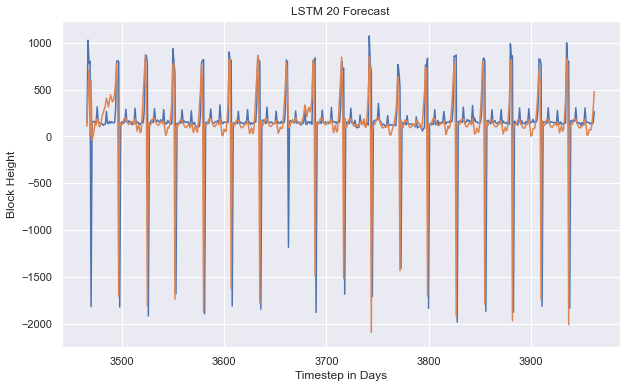

In [38]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Block Height')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(x_test_diff.index, x_test_diff)
plt.plot(x_test_diff.index, rnn_unscaled_forecast)
plt.show()

In [39]:
lstm = mean_absolute_error(x_test_diff, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM'] = lstm
model_mae_scores

{'naive': 288.7424547283702,
 'SMA 20': 1523.8221327967783,
 'SMA 5': 418.7424547283716,
 'ARIMA': 317.455575850708,
 'ARIMA 2': 271.30754117987044,
 'LSTM': 220.52887592661068}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

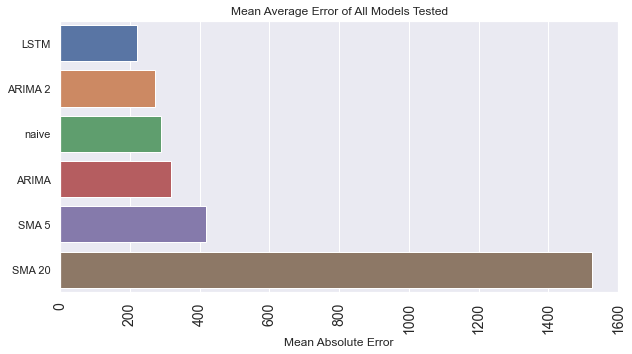

In [40]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

# CNN

Full CNNs are becoming more commom to detect trends in NLP and time series modeling. A popular architecture is the WaveNet architecture proposed by Deep Mind in 2016.

In WaveNet, every layer has kernel size 2, stride 1, causal padding, and using ReLU activation functions. However, the 2nd layer uses a dilation rate of 2. This means it skips every other input timestep. The next layer uses a dilation rate of 4 which means it skips every 3 input time steps. The fourth layer uses a dilation rate of 8 which means it skips every 7 timesteps out of 8. This patter continues which enables the lower layers to learn shorter term patterns while the deeper layers learn the longer term patterns.

The last layer acts as a dense layer to output a single value.

In [41]:
def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Find the learning rate

In [42]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

C:\Users\paletto\Anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 2s 11ms/step - loss: 0.2183 - mae: 0.6549 - lr: 1.0000e-04
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 0.2005 - mae: 0.6271 - lr: 1.0798e-04
Epoch 3/100
24/24 [==============================] - 0s 10ms/step - loss: 0.1758 - mae: 0.5862 - lr: 1.1659e-04
Epoch 4/100
24/24 [==============================] - 0s 10ms/step - loss: 0.1302 - mae: 0.5006 - lr: 1.2589e-04
Epoch 5/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0593 - mae: 0.3200 - lr: 1.3594e-04
Epoch 6/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0186 - mae: 0.1410 - lr: 1.4678e-04
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0125 - mae: 0.1022 - lr: 1.5849e-04
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0096 - mae: 0.0858 - lr: 1.7113e-04
Epoch 9/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0078 - mae: 0.0743 - lr: 1.8

24/24 [==============================] - 0s 10ms/step - loss: 0.0038 - mae: 0.0401 - lr: 0.0293
Epoch 76/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0039 - mae: 0.0434 - lr: 0.0316
Epoch 77/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0039 - mae: 0.0438 - lr: 0.0341
Epoch 78/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0042 - mae: 0.0540 - lr: 0.0369
Epoch 79/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0044 - mae: 0.0615 - lr: 0.0398
Epoch 80/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0047 - mae: 0.0559 - lr: 0.0430
Epoch 81/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0038 - mae: 0.0349 - lr: 0.0464
Epoch 82/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0040 - mae: 0.0426 - lr: 0.0501
Epoch 83/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0061 - mae: 0.0777 - lr: 0.0541
Epoch 84/100
24/24 [==============

(0.0001, 0.1, 0.0, 0.04)

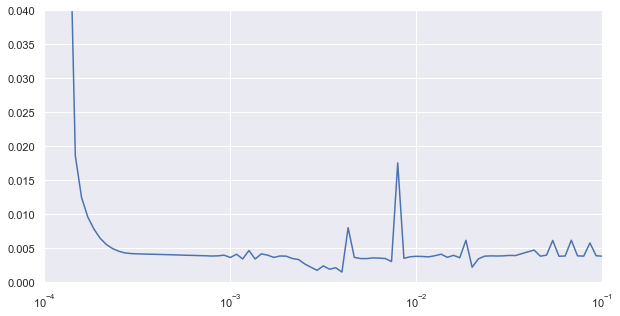

In [45]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .04])

In [46]:
#This is the best learning rate
history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]

0.0014632204547524452

In [47]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=1e-3)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
23/23 [==============================] - 3s 72ms/step - loss: 0.0508 - mae: 0.2270 - val_loss: 0.0042 - val_mae: 0.0521
Epoch 2/500
23/23 [==============================] - 1s 61ms/step - loss: 0.0054 - mae: 0.0688 - val_loss: 0.0052 - val_mae: 0.0834
Epoch 3/500
23/23 [==============================] - 1s 63ms/step - loss: 0.0052 - mae: 0.0678 - val_loss: 0.0042 - val_mae: 0.0561
Epoch 4/500
23/23 [==============================] - 1s 61ms/step - loss: 0.0052 - mae: 0.0689 - val_loss: 0.0042 - val_mae: 0.0657
Epoch 5/500
23/23 [==============================] - 1s 63ms/step - loss: 0.0048 - mae: 0.0621 - val_loss: 0.0040 - val_mae: 0.0539
Epoch 6/500
23/23 [==============================] - 1s 60ms/step - loss: 0.0048 - mae: 0.0625 - val_loss: 0.0041 - val_mae: 0.0641
Epoch 7/500
23/23 [==============================] - 2s 63ms/step - loss: 0.0047 - mae: 0.0615 - val_loss: 0.0037 - val_mae: 0.0495
Epoch 8/500
23/23 [==============================] - 1s 59ms/step - loss: 0.

23/23 [==============================] - 1s 62ms/step - loss: 7.4966e-04 - mae: 0.0196 - val_loss: 6.7826e-04 - val_mae: 0.0175
Epoch 61/500
23/23 [==============================] - 1s 61ms/step - loss: 7.8631e-04 - mae: 0.0217 - val_loss: 7.0590e-04 - val_mae: 0.0219
Epoch 62/500
23/23 [==============================] - 1s 61ms/step - loss: 7.5534e-04 - mae: 0.0201 - val_loss: 6.6059e-04 - val_mae: 0.0164
Epoch 63/500
23/23 [==============================] - 1s 62ms/step - loss: 7.7554e-04 - mae: 0.0212 - val_loss: 6.5975e-04 - val_mae: 0.0189
Epoch 64/500
23/23 [==============================] - 1s 61ms/step - loss: 7.3272e-04 - mae: 0.0187 - val_loss: 6.8698e-04 - val_mae: 0.0184
Epoch 65/500
23/23 [==============================] - 1s 61ms/step - loss: 7.4876e-04 - mae: 0.0198 - val_loss: 6.7018e-04 - val_mae: 0.0198
Epoch 66/500
23/23 [==============================] - 1s 63ms/step - loss: 7.6291e-04 - mae: 0.0207 - val_loss: 6.5709e-04 - val_mae: 0.0174
Epoch 67/500
23/23 [======

23/23 [==============================] - 1s 63ms/step - loss: 6.4097e-04 - mae: 0.0160 - val_loss: 6.0438e-04 - val_mae: 0.0165
Epoch 119/500
23/23 [==============================] - 1s 63ms/step - loss: 6.2027e-04 - mae: 0.0145 - val_loss: 5.5096e-04 - val_mae: 0.0124
Epoch 120/500
23/23 [==============================] - 2s 66ms/step - loss: 6.7746e-04 - mae: 0.0182 - val_loss: 6.3296e-04 - val_mae: 0.0191
Epoch 121/500
23/23 [==============================] - 2s 66ms/step - loss: 6.2572e-04 - mae: 0.0149 - val_loss: 5.6452e-04 - val_mae: 0.0119
Epoch 122/500
23/23 [==============================] - 2s 64ms/step - loss: 6.0859e-04 - mae: 0.0136 - val_loss: 5.5959e-04 - val_mae: 0.0135
Epoch 123/500
23/23 [==============================] - 2s 65ms/step - loss: 6.3993e-04 - mae: 0.0157 - val_loss: 6.2468e-04 - val_mae: 0.0176
Epoch 124/500
23/23 [==============================] - 2s 65ms/step - loss: 6.9949e-04 - mae: 0.0194 - val_loss: 5.7431e-04 - val_mae: 0.0134
Epoch 125/500
23/23 

23/23 [==============================] - 1s 62ms/step - loss: 6.6066e-04 - mae: 0.0151 - val_loss: 6.0746e-04 - val_mae: 0.0125
Epoch 177/500
23/23 [==============================] - 1s 62ms/step - loss: 6.5885e-04 - mae: 0.0151 - val_loss: 6.1910e-04 - val_mae: 0.0167
Epoch 178/500
23/23 [==============================] - 1s 63ms/step - loss: 6.4671e-04 - mae: 0.0146 - val_loss: 6.3367e-04 - val_mae: 0.0173
Epoch 179/500
23/23 [==============================] - 1s 62ms/step - loss: 6.5737e-04 - mae: 0.0152 - val_loss: 5.9843e-04 - val_mae: 0.0130
Epoch 180/500
23/23 [==============================] - 1s 62ms/step - loss: 6.4825e-04 - mae: 0.0146 - val_loss: 6.0035e-04 - val_mae: 0.0150
Epoch 181/500
23/23 [==============================] - 2s 65ms/step - loss: 6.4001e-04 - mae: 0.0145 - val_loss: 5.9660e-04 - val_mae: 0.0154
Epoch 182/500
23/23 [==============================] - 1s 63ms/step - loss: 6.4908e-04 - mae: 0.0151 - val_loss: 5.8562e-04 - val_mae: 0.0133
Epoch 183/500
23/23 

In [48]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

In [49]:
# Use best model to get forecasts
cnn_forecast = model_forecast(model, np.concatenate((normalized_x_valid[-29:], normalized_x_test)), window_size)
# spy_normalized_to_traindata
cnn_forecast = cnn_forecast[:,-1,0]
print(cnn_forecast.shape)
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()

(497,)


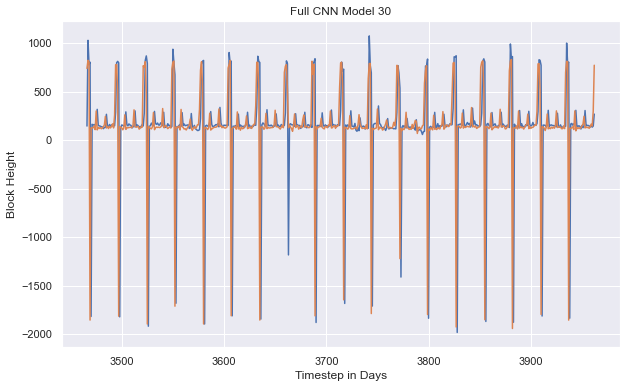

In [50]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Block Height')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(x_test_diff.index, x_test_diff)
plt.plot(x_test_diff.index, cnn_unscaled_forecast)

In [51]:
# Calculate MAE
cnn = mean_absolute_error(x_test_diff, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN'] = cnn
model_mae_scores

{'naive': 288.7424547283702,
 'SMA 20': 1523.8221327967783,
 'SMA 5': 418.7424547283716,
 'ARIMA': 317.455575850708,
 'ARIMA 2': 271.30754117987044,
 'LSTM': 220.52887592661068,
 'CNN': 228.21421517692582}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

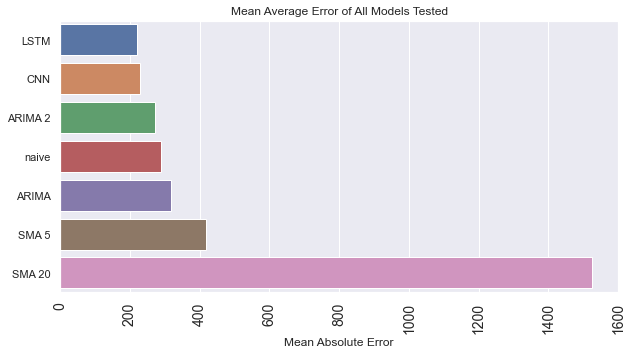

In [52]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

## Weekly data

### Train/val/test split

Utilizzando ser.diff() su una serie il suo valore più vecchio (quello in [0]) diventa nan. Scelgo comunque di non cancellarlo definitivamente me di toglierlo solo quando serve perchè così, sostituendo il nan con il più vecchio valore iniziare della serie (ser.diff()[0] = ser[0]), posso ricostruire la serie originale facendo ser.cumsum()

In [53]:
bh_week = block_height.set_index('Timestamp')
bh_week = bh_week.resample('W').mean()
del bh_week['year']
bh_week.reset_index(inplace=True)

In [54]:
tr_idx_w = bh_week.index[int((train_split_index/block_height.shape[0])*bh_week.shape[0])]
te_idx_w = bh_week.index[int((test_split_index/block_height.shape[0])*bh_week.shape[0])]
print('data fine train =',bh_week['Timestamp'][tr_idx_w], ' data inizio test =', bh_week['Timestamp'][te_idx_w])

data fine train = 2019-01-06 00:00:00  data inizio test = 2020-07-05 00:00:00


In [55]:
x_trw = bh_week.loc[:tr_idx_w,'Value']
x_tew = bh_week.loc[te_idx_w:,'Value']
x_vaw = bh_week.loc[tr_idx_w:te_idx_w,'Value']

x_trw_d = bh_week.diff().loc[:tr_idx_w,'Value']
x_tew_d = bh_week.diff().loc[te_idx_w:,'Value']
x_vaw_d = bh_week.diff().loc[tr_idx_w:te_idx_w,'Value']

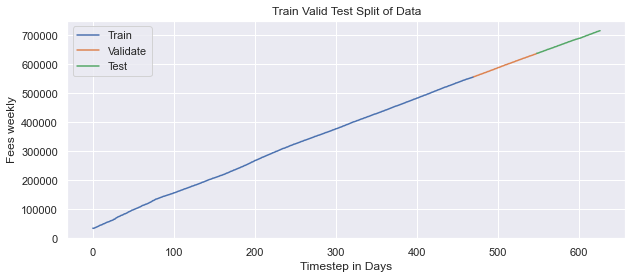

In [56]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 4]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_trw, label = 'Train')
plt.plot(x_vaw, label = 'Validate')
plt.plot(x_tew, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Fees weekly')
plt.xlabel('Timestep in Days')
plt.legend()

## ARIMA(s)

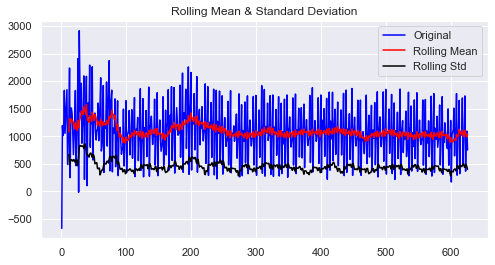

Results of Dickey-Fuller Test:
p-value = 0.0314. The series is likely non-stationary.
Test Statistic                  -3.039626
p-value                          0.031356
#Lags Used                      19.000000
Number of Observations Used    606.000000
Critical Value (1%)             -3.441187
Critical Value (5%)             -2.866321
Critical Value (10%)            -2.569316
dtype: float64


In [57]:
test_stationarity(bh_week['Value'].diff().dropna())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=inf, Time=0.92 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=47239.339, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=46582.046, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=inf, Time=0.59 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=46580.265, Time=0.05 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=46582.052, Time=0.12 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=46553.178, Time=0.59 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=46524.815, Time=0.97 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=46583.352, Time=0.23 sec
 ARIMA(1,2,0)(2,0,2)[7]             : AIC=46503.899, Time=0.85 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=46491.981, Time=1.56 sec
 ARIMA(1,2,0)(0,0,2)[7]             : AIC=46583.652, Time=0.27 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=47201.795, Time=0.74 sec
 ARIMA(2,2,0)(1,0,2)[7]             : AIC=46407.110, Time=0.35 sec
 ARIMA(2,2,0)(0,0,2)[7]        

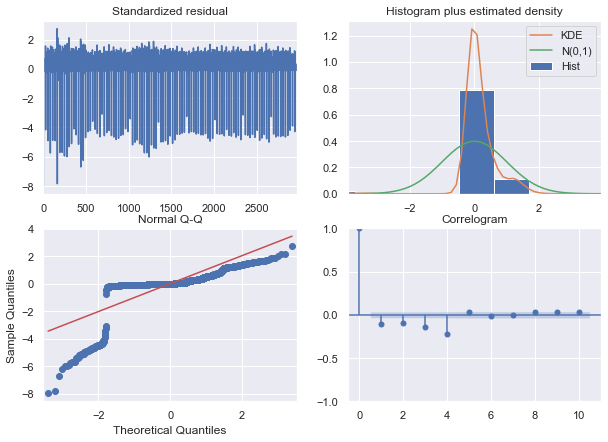

In [183]:
model = model_auto_sarimax(y = x_trw_d, seasonality = 12, seasonal_flag = True, exogenous_variable = None)

In [58]:
# fit model
block_arima = sm.tsa.arima.ARIMA(x_train_diff.dropna(), order=(3,2,0), seasonal_order=(0,0,1,7))
block_arima_fit = block_arima.fit()

residuals = block_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0)
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


NameError: name 'normaltest' is not defined

In [59]:
# Create list of x train valuess
history = [x for x in x_vaw_d]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_tew_d)

# loop through every data point
for time_point in list(x_tew_d.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,2,0), seasonal_order=(0,0,1,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_tew_d[time_point]
    history.append(true_test_value)
        
MAE_error = mean_absolute_error(x_tew_d, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing Mean Squared Error is 525.799320863736


In [61]:
model_w_mae_scores = {}

In [63]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_tew_d, model_predictions)

# Save to our dictionary of model mae scores
model_w_mae_scores['ARIMA'] = arima_mae
model_w_mae_scores

{'ARIMA': 525.799320863736}

In [64]:
history = [x for x in x_vaw_d]
model_predictions = []

# Count number of test data points
N_test_observations = len(x_tew_d)

model = sm.tsa.arima.ARIMA(history, order=(3,2,0), seasonal_order=(0,0,1,7))
model_fit = model.fit()

output = model_fit.forecast(N_test_observations)
for el in output:
    model_predictions.append(el)
    history.append(el)

MAE_error = mean_absolute_error(x_tew_d, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

Testing Mean Squared Error is 417.6427607173695


In [65]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae2 = mean_absolute_error(x_tew_d, model_predictions)

# Save to our dictionary of model mae scores
model_w_mae_scores['ARIMA 2'] = arima_mae2
model_w_mae_scores

{'ARIMA': 525.799320863736, 'ARIMA 2': 417.6427607173695}

## LSTM

Ho provato a cambiare la window, il numero di celle lstm nella rete e il suo learning rate ma alla fine ottengo sempre una predizioe piatta...

In [110]:
# SCELTA DEL LEARNING RATE
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 10
train_set = sequential_window_dataset(x_trw_d.dropna(), window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

C:\Users\paletto\Anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/100
46/46 [==============================] - 4s 35ms/step - loss: 1119.8074 - mae: 1120.3074 - lr: 1.0000e-05
Epoch 2/100
46/46 [==============================] - 1s 11ms/step - loss: 1119.4896 - mae: 1119.9896 - lr: 1.1220e-05
Epoch 3/100
46/46 [==============================] - 1s 14ms/step - loss: 1119.1097 - mae: 1119.6097 - lr: 1.2589e-05
Epoch 4/100
46/46 [==============================] - 1s 21ms/step - loss: 1118.6342 - mae: 1119.1342 - lr: 1.4125e-05
Epoch 5/100
46/46 [==============================] - 1s 11ms/step - loss: 1118.0010 - mae: 1118.5010 - lr: 1.5849e-05
Epoch 6/100
46/46 [==============================] - 1s 20ms/step - loss: 1117.0847 - mae: 1117.5847 - lr: 1.7783e-05
Epoch 7/100
46/46 [==============================] - 1s 23ms/step - loss: 1115.8768 - mae: 1116.3768 - lr: 1.9953e-05
Epoch 8/100
46/46 [==============================] - 1s 11ms/step - loss: 1114.6100 - mae: 1115.1100 - lr: 2.2387e-05
Epoch 9/100
46/46 [==============================] - 1s 

46/46 [==============================] - 1s 25ms/step - loss: 385.1144 - mae: 385.6144 - lr: 0.0282
Epoch 71/100
46/46 [==============================] - 1s 19ms/step - loss: 361.5755 - mae: 362.0755 - lr: 0.0316
Epoch 72/100
46/46 [==============================] - 2s 33ms/step - loss: 348.2463 - mae: 348.7456 - lr: 0.0355
Epoch 73/100
46/46 [==============================] - 2s 35ms/step - loss: 344.7865 - mae: 345.2848 - lr: 0.0398
Epoch 74/100
46/46 [==============================] - 2s 34ms/step - loss: 344.4502 - mae: 344.9496 - lr: 0.0447384.4507 -
Epoch 75/100
46/46 [==============================] - 2s 33ms/step - loss: 344.4268 - mae: 344.9250 - lr: 0.0501
Epoch 76/100
46/46 [==============================] - 2s 36ms/step - loss: 344.4960 - mae: 344.9948 - lr: 0.0562
Epoch 77/100
46/46 [==============================] - 2s 36ms/step - loss: 344.6154 - mae: 345.1153 - lr: 0.0631
Epoch 78/100
46/46 [==============================] - 2s 36ms/step - loss: 344.6839 - mae: 345.1832

(0.0001, 0.1, 0.0, 500.0)

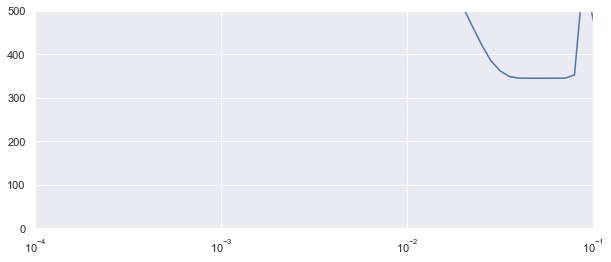

In [114]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 500])

In [115]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 20
train_set = sequential_window_dataset(x_trw_d.dropna(), window_size)
valid_set = sequential_window_dataset(x_vaw_d, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=0.07)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

C:\Users\paletto\Anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/500
     23/Unknown - 4s 44ms/step - loss: 1065.1885 - mae: 1065.6885

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


23/23 [==============================] - 9s 278ms/step - loss: 1065.1885 - mae: 1065.6885 - val_loss: 909.0945 - val_mae: 909.5945
Epoch 2/500
23/23 [==============================] - ETA: 0s - loss: 934.4604 - mae: 934.9604

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


23/23 [==============================] - 6s 272ms/step - loss: 934.4604 - mae: 934.9604 - val_loss: 774.4370 - val_mae: 774.9360
Epoch 3/500
21/23 [==========================>...] - ETA: 0s - loss: 819.4850 - mae: 819.9850

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


23/23 [==============================] - 5s 234ms/step - loss: 809.8361 - mae: 810.3361 - val_loss: 666.6032 - val_mae: 667.1032
Epoch 4/500
21/23 [==========================>...] - ETA: 0s - loss: 720.1181 - mae: 720.6181

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


23/23 [==============================] - 5s 239ms/step - loss: 710.7692 - mae: 711.2692 - val_loss: 574.1646 - val_mae: 574.6638
Epoch 5/500
22/23 [===========================>..] - ETA: 0s - loss: 629.8220 - mae: 630.3220

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


23/23 [==============================] - 5s 222ms/step - loss: 625.0778 - mae: 625.5778 - val_loss: 496.4182 - val_mae: 496.9182
Epoch 6/500
21/23 [==========================>...] - ETA: 0s - loss: 559.7511 - mae: 560.2511

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


23/23 [==============================] - 6s 256ms/step - loss: 551.3160 - mae: 551.8160 - val_loss: 431.6582 - val_mae: 432.1582
Epoch 7/500
21/23 [==========================>...] - ETA: 0s - loss: 493.9188 - mae: 494.4188

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


23/23 [==============================] - 5s 214ms/step - loss: 485.9313 - mae: 486.4313 - val_loss: 374.3310 - val_mae: 374.8310
Epoch 8/500
21/23 [==========================>...] - ETA: 0s - loss: 433.0598 - mae: 433.5598

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


23/23 [==============================] - 6s 254ms/step - loss: 425.4888 - mae: 425.9887 - val_loss: 320.8305 - val_mae: 321.3305
Epoch 9/500
22/23 [===========================>..] - ETA: 0s - loss: 384.5447 - mae: 385.0446

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


23/23 [==============================] - 5s 226ms/step - loss: 380.3333 - mae: 380.8332 - val_loss: 292.5126 - val_mae: 293.0126
Epoch 10/500
23/23 [==============================] - ETA: 0s - loss: 355.5448 - mae: 356.0448

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


23/23 [==============================] - 6s 249ms/step - loss: 355.5448 - mae: 356.0448 - val_loss: 281.4601 - val_mae: 281.9601
Epoch 11/500
23/23 [==============================] - 1s 22ms/step - loss: 345.9000 - mae: 346.3991 - val_loss: 282.8654 - val_mae: 283.3654
Epoch 12/500
23/23 [==============================] - 0s 17ms/step - loss: 344.4967 - mae: 344.9957 - val_loss: 283.9210 - val_mae: 284.4171
Epoch 13/500
23/23 [==============================] - 1s 28ms/step - loss: 344.3767 - mae: 344.8762 - val_loss: 283.8929 - val_mae: 284.3900
Epoch 14/500
23/23 [==============================] - 0s 16ms/step - loss: 344.4611 - mae: 344.9611 - val_loss: 283.7242 - val_mae: 284.2180
Epoch 15/500
23/23 [==============================] - 0s 16ms/step - loss: 344.3438 - mae: 344.8426 - val_loss: 281.6916 - val_mae: 282.1916
Epoch 16/500
23/23 [==============================] - 0s 16ms/step - loss: 344.7469 - mae: 345.2452 - val_loss: 282.8267 - val_mae: 283.3267
Epoch 17/500
23/23 [=====

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


23/23 [==============================] - 5s 213ms/step - loss: 344.4822 - mae: 344.9821 - val_loss: 281.3571 - val_mae: 281.8571
Epoch 23/500
23/23 [==============================] - 0s 15ms/step - loss: 345.8766 - mae: 346.3746 - val_loss: 282.8800 - val_mae: 283.3800
Epoch 24/500
23/23 [==============================] - 0s 18ms/step - loss: 344.4324 - mae: 344.9319 - val_loss: 283.5988 - val_mae: 284.0962
Epoch 25/500
23/23 [==============================] - 1s 26ms/step - loss: 344.3428 - mae: 344.8423 - val_loss: 283.4047 - val_mae: 283.9047
Epoch 26/500
23/23 [==============================] - 0s 15ms/step - loss: 344.9070 - mae: 345.4060 - val_loss: 282.5008 - val_mae: 283.0008
Epoch 27/500
23/23 [==============================] - 0s 16ms/step - loss: 345.6967 - mae: 346.1967 - val_loss: 282.5294 - val_mae: 283.0294
Epoch 28/500
23/23 [==============================] - 0s 16ms/step - loss: 345.3370 - mae: 345.8370 - val_loss: 285.3426 - val_mae: 285.8425
Epoch 29/500
23/23 [=====

In [116]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(x_tew_d[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()

C:\Users\paletto\AppData\Local\Temp/ipykernel_1012/1214430412.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  rnn_forecast = model.predict(x_tew_d[np.newaxis,:])


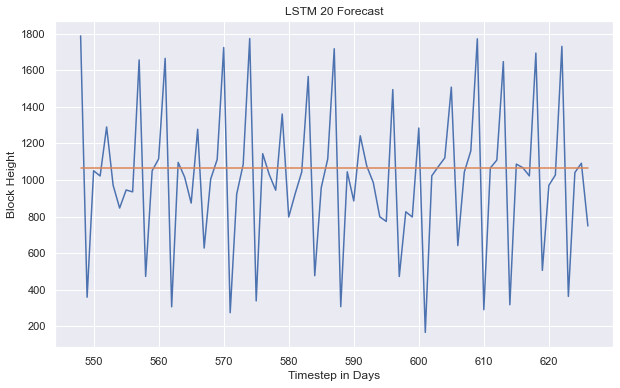

In [117]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Block Height')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(x_tew_d.index, x_tew_d)
plt.plot(x_tew_d.index, rnn_forecast)
plt.show()

## CNN


In [118]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(x_trw_d.dropna(), window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

C:\Users\paletto\Anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/100
4/4 [==============================] - 2s 62ms/step - loss: 1138.6348 - mae: 1139.1346 - lr: 1.0000e-04
Epoch 2/100
4/4 [==============================] - 0s 22ms/step - loss: 1135.1519 - mae: 1135.6517 - lr: 1.0798e-04
Epoch 3/100
4/4 [==============================] - 1s 80ms/step - loss: 1131.4958 - mae: 1131.9958 - lr: 1.1659e-04
Epoch 4/100
4/4 [==============================] - 0s 58ms/step - loss: 1127.5308 - mae: 1128.0308 - lr: 1.2589e-04
Epoch 5/100
4/4 [==============================] - 0s 68ms/step - loss: 1123.3792 - mae: 1123.8792 - lr: 1.3594e-04
Epoch 6/100
4/4 [==============================] - 0s 28ms/step - loss: 1119.1227 - mae: 1119.6227 - lr: 1.4678e-04
Epoch 7/100
4/4 [==============================] - 0s 24ms/step - loss: 1114.7443 - mae: 1115.2443 - lr: 1.5849e-04
Epoch 8/100
4/4 [==============================] - 0s 26ms/step - loss: 1109.9760 - mae: 1110.4760 - lr: 1.7113e-04
Epoch 9/100
4/4 [==============================] - 0s 21ms/step - loss: 

4/4 [==============================] - 0s 21ms/step - loss: 1272.7120 - mae: 1273.2120 - lr: 0.0251
Epoch 74/100
4/4 [==============================] - 0s 24ms/step - loss: 2153.1179 - mae: 2153.6179 - lr: 0.0271
Epoch 75/100
4/4 [==============================] - 0s 24ms/step - loss: 1114.6405 - mae: 1115.1405 - lr: 0.0293
Epoch 76/100
4/4 [==============================] - 0s 21ms/step - loss: 1099.5052 - mae: 1100.0051 - lr: 0.0316
Epoch 77/100
4/4 [==============================] - 0s 24ms/step - loss: 768.4960 - mae: 768.9958 - lr: 0.0341
Epoch 78/100
4/4 [==============================] - 0s 21ms/step - loss: 554.1259 - mae: 554.6258 - lr: 0.0369
Epoch 79/100
4/4 [==============================] - 0s 23ms/step - loss: 713.7849 - mae: 714.2849 - lr: 0.0398
Epoch 80/100
4/4 [==============================] - 0s 22ms/step - loss: 526.4343 - mae: 526.9341 - lr: 0.0430
Epoch 81/100
4/4 [==============================] - 0s 22ms/step - loss: 631.8914 - mae: 632.3911 - lr: 0.0464
Epoch 

(0.0001, 0.1, 0.0, 1000.0)

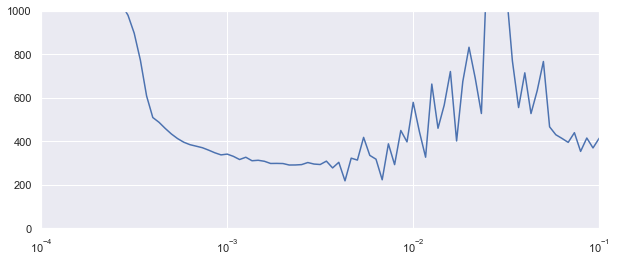

In [119]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 1000])

In [120]:
#This is the best learning rate
history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]

0.0042986623

In [131]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 5
train_set = seq2seq_window_dataset(x_trw_d.dropna(), window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_vaw_d, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=4e-3)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

C:\Users\paletto\Anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/500
4/4 [==============================] - 1s 123ms/step - loss: 956.2960 - mae: 956.7957 - val_loss: 758.9573 - val_mae: 759.4573
Epoch 2/500
4/4 [==============================] - 0s 52ms/step - loss: 706.5940 - mae: 707.0941 - val_loss: 507.5552 - val_mae: 508.0552
Epoch 3/500
4/4 [==============================] - 0s 47ms/step - loss: 613.7354 - mae: 614.2355 - val_loss: 614.5676 - val_mae: 615.0676
Epoch 4/500
4/4 [==============================] - 0s 53ms/step - loss: 627.2075 - mae: 627.7070 - val_loss: 431.2095 - val_mae: 431.7095
Epoch 5/500
4/4 [==============================] - 0s 52ms/step - loss: 591.8499 - mae: 592.3497 - val_loss: 424.1400 - val_mae: 424.6400
Epoch 6/500
4/4 [==============================] - 0s 53ms/step - loss: 501.9327 - mae: 502.4325 - val_loss: 413.8811 - val_mae: 414.3804
Epoch 7/500
4/4 [==============================] - 0s 47ms/step - loss: 505.8771 - mae: 506.3770 - val_loss: 483.1449 - val_mae: 483.6449
Epoch 8/500
4/4 [================

Epoch 60/500
4/4 [==============================] - 0s 46ms/step - loss: 368.2755 - mae: 368.7751 - val_loss: 300.3773 - val_mae: 300.8764
Epoch 61/500
4/4 [==============================] - 0s 48ms/step - loss: 347.2935 - mae: 347.7930 - val_loss: 310.1273 - val_mae: 310.6259
Epoch 62/500
4/4 [==============================] - 0s 46ms/step - loss: 342.5302 - mae: 343.0300 - val_loss: 346.7312 - val_mae: 347.2310
Epoch 63/500
4/4 [==============================] - 0s 46ms/step - loss: 345.8496 - mae: 346.3490 - val_loss: 366.9644 - val_mae: 367.4643
Epoch 64/500
4/4 [==============================] - 0s 46ms/step - loss: 362.7479 - mae: 363.2474 - val_loss: 406.9893 - val_mae: 407.4893
Epoch 65/500
4/4 [==============================] - 0s 46ms/step - loss: 350.3596 - mae: 350.8589 - val_loss: 330.8278 - val_mae: 331.3278
Epoch 66/500
4/4 [==============================] - 0s 52ms/step - loss: 371.3628 - mae: 371.8625 - val_loss: 266.4746 - val_mae: 266.9731
Epoch 67/500
4/4 [=========

Epoch 119/500
4/4 [==============================] - 0s 46ms/step - loss: 311.0303 - mae: 311.5294 - val_loss: 283.9881 - val_mae: 284.4881
Epoch 120/500
4/4 [==============================] - 0s 47ms/step - loss: 322.3537 - mae: 322.8537 - val_loss: 269.6656 - val_mae: 270.1636
Epoch 121/500
4/4 [==============================] - 0s 46ms/step - loss: 312.1430 - mae: 312.6422 - val_loss: 258.0450 - val_mae: 258.5446
Epoch 122/500
4/4 [==============================] - 0s 47ms/step - loss: 296.9467 - mae: 297.4465 - val_loss: 291.2793 - val_mae: 291.7793
Epoch 123/500
4/4 [==============================] - 0s 46ms/step - loss: 314.4974 - mae: 314.9968 - val_loss: 282.5861 - val_mae: 283.0855
Epoch 124/500
4/4 [==============================] - 0s 46ms/step - loss: 324.9031 - mae: 325.4029 - val_loss: 276.0923 - val_mae: 276.5923
Epoch 125/500
4/4 [==============================] - 0s 46ms/step - loss: 294.7815 - mae: 295.2808 - val_loss: 270.4172 - val_mae: 270.9172
Epoch 126/500
4/4 [=

4/4 [==============================] - 0s 45ms/step - loss: 300.2733 - mae: 300.7730 - val_loss: 270.1241 - val_mae: 270.6240
Epoch 178/500
4/4 [==============================] - 0s 45ms/step - loss: 300.1053 - mae: 300.6046 - val_loss: 268.6098 - val_mae: 269.1098
Epoch 179/500
4/4 [==============================] - 0s 45ms/step - loss: 298.0446 - mae: 298.5438 - val_loss: 262.6652 - val_mae: 263.1640
Epoch 180/500
4/4 [==============================] - 0s 46ms/step - loss: 299.6443 - mae: 300.1433 - val_loss: 250.7655 - val_mae: 251.2655
Epoch 181/500
4/4 [==============================] - 0s 46ms/step - loss: 295.8993 - mae: 296.3990 - val_loss: 244.7799 - val_mae: 245.2775
Epoch 182/500
4/4 [==============================] - 0s 46ms/step - loss: 260.5594 - mae: 261.0590 - val_loss: 256.1939 - val_mae: 256.6931
Epoch 183/500
4/4 [==============================] - 0s 45ms/step - loss: 286.4879 - mae: 286.9877 - val_loss: 266.9012 - val_mae: 267.4012
Epoch 184/500
4/4 [===============

4/4 [==============================] - 0s 46ms/step - loss: 257.9445 - mae: 258.4439 - val_loss: 268.2829 - val_mae: 268.7810
Epoch 236/500
4/4 [==============================] - 0s 45ms/step - loss: 283.0201 - mae: 283.5189 - val_loss: 251.6333 - val_mae: 252.1332
Epoch 237/500
4/4 [==============================] - 0s 45ms/step - loss: 276.1882 - mae: 276.6878 - val_loss: 248.5215 - val_mae: 249.0213
Epoch 238/500
4/4 [==============================] - 0s 45ms/step - loss: 283.2370 - mae: 283.7367 - val_loss: 249.7623 - val_mae: 250.2605
Epoch 239/500
4/4 [==============================] - 0s 45ms/step - loss: 262.8326 - mae: 263.3322 - val_loss: 278.3184 - val_mae: 278.8175
Epoch 240/500
4/4 [==============================] - 0s 46ms/step - loss: 287.4497 - mae: 287.9492 - val_loss: 269.6346 - val_mae: 270.1344
Epoch 241/500
4/4 [==============================] - 0s 45ms/step - loss: 276.9520 - mae: 277.4517 - val_loss: 255.1474 - val_mae: 255.6474
Epoch 242/500
4/4 [===============

In [134]:
model = keras.models.load_model("my_checkpoint.h5")
# Use best model to get forecasts
cnn_forecast = model_forecast(model, np.concatenate((x_vaw_d[-5:], x_tew_d)), window_size)
# spy_normalized_to_traindata
cnn_forecast = cnn_forecast[:,-1,0]
print(cnn_forecast.shape)
#cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()

(80,)


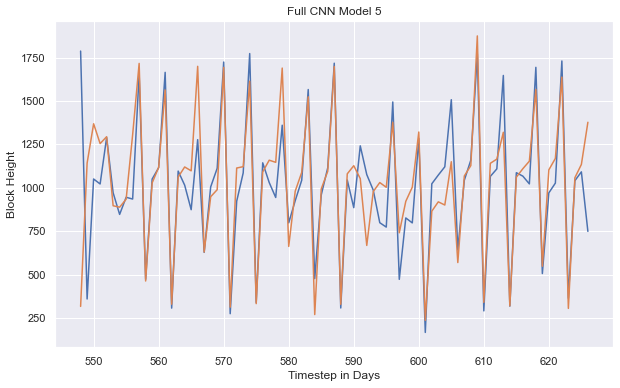

In [136]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Block Height')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(x_tew_d.index, x_tew_d)
plt.plot(x_tew_d.index, cnn_forecast[:-1])

In [138]:
cnn2 = mean_absolute_error(x_tew_d, cnn_forecast[:-1])

# Save to our dictionary of model mae scores
model_w_mae_scores['CNN'] = cnn2
model_w_mae_scores

{'ARIMA': 525.799320863736,
 'ARIMA 2': 417.6427607173695,
 'CNN': 145.5659999927886}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

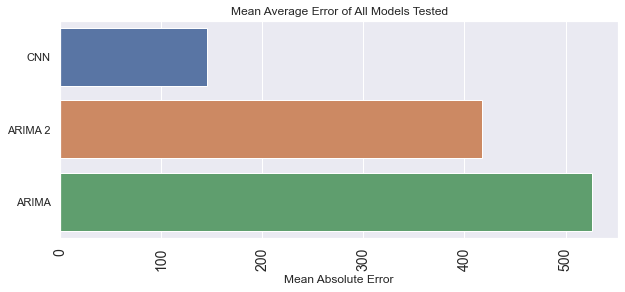

In [139]:
model_w_mae_scores2 = pd.Series(model_w_mae_scores)
model_w_mae_scores2

# Sort vales for clean bar chart
order = model_w_mae_scores2.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')